In [1]:
%run /Users/maayanlab/Library/Mobile\ Documents/com~apple~CloudDocs/Documents/Projects/scripts/init.ipy
# %run /Users/denis/Documents/Projects/scripts/init.ipy
os.chdir(os.getcwd().replace('/pipeline/notebooks', ''));

/Users/maayanlab/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
count_dataframe = pd.read_table('./s1-expression.dir/ensembl/exon.transcriptID-ensembl.txt', index_col='gene_symbol')
logcpm_dataframe = (count_dataframe/count_dataframe.sum())*10**6
logcpm_dataframe.head()

BBZ        BEL        BEQ        BFH        BGX        BJW  \
gene_symbol                                                                     
A1BG          0.000000   0.192392   0.000000   0.000000   0.000000   0.135727   
A1BG-AS1      0.000000   0.192392   0.000000   0.000000   0.000000   0.271455   
A1CF          0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
A2M          42.470648  91.001603  34.109395  73.275754  52.449522  61.077298   
A2M-AS1       0.676823   1.410878   0.544299   0.771324   0.368498   0.135727   

                   BKK        BMS        BNT        BNW        BPY        BQZ  \
gene_symbol                                                                     
A1BG          0.122279   0.222890   0.307923   0.000000   0.187918   0.000000   
A1BG-AS1      0.244557   0.222890   0.000000   0.000000   0.187918   0.271248   
A1CF          0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
A2M          71.288466  57.840065  68.769381  73.128816  70.093506  52.622107   
A2M-AS1       0.244557   0.222890   0.410563   0.425168   0.375836   0.678120   

                   CCI        CCQ        CDS        CFV        CGE        CHH  \
gene_symbol                                                                     
A1BG          0.115196   0.000000   0.472464   0.000000   0.116098   0.242797   
A1BG-AS1      0.115196   0.000000   0.314976   0.000000   0.000000   0.364196   
A1CF          0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
A2M          39.166712  79.525362  42.049277  41.250602  36.803116  51.108806   
A2M-AS1       0.806373   0.809831   0.629952   0.181721   0.232196   0.485594   

                   CHX        CKA  
gene_symbol                        
A1BG          0.220192   0.295120  
A1BG-AS1      0.440384   0.147560  
A1CF          0.000000   0.000000  
A2M          54.277365  36.004663  
A2M-AS1       0.220192   1.328041

In [3]:
metadata_dataframe = pd.read_table('pipeline/notebooks/sample_metadata.txt').replace('PPI_REE', 'PPI-REE').replace('Post_PPI', 'Post-PPI').replace('Pre_PPI', 'Pre-PPI')
metadata_dataframe.head()

sample group treatment patient_nr
0    BEL   EoE   Pre-PPI        p01
1    BJW   EoE   Pre-PPI        p02
2    BBZ   EoE   Pre-PPI        p03
3    BFH   EoE   Pre-PPI        p04
4    BKK   EoE   Pre-PPI        p05

In [11]:
genes = ['CCL26', 'CAPN14', 'SLC9A3', 'AHR', 'ARNT', 'AHRR', 'CYP1A1', 'CYP2S1']

## 1. Gene Boxplot

In [8]:
%%R
gene_boxplot <- function(plot_dataframe, gene_symbol) {
   plot_dataframe$treatment <- factor(plot_dataframe$treatment, levels = c('Pre-PPI','Post-PPI'), ordered = TRUE)
    gp <- ggplot(plot_dataframe, aes(x=treatment, y=expression, fill=treatment)) +
        geom_boxplot() +
        facet_wrap(~group) +
        scale_fill_manual(values=c('white', 'grey')) +
        labs(title = gene_symbol, x = '', y = 'Expression (logCPM)', color = '', fill='') +
        guides(fill=FALSE) +
        theme_classic() +
        theme(axis.title.x = element_text(vjust=-1), axis.title.y = element_text(vjust=2.5), axis.line = element_line(colour = 'black', size=0.2), strip.background = element_rect(color='black', fill='white', size=0), plot.title = element_text(hjust = 0.5)) ;
    print(gp);
    ggsave(paste0('pipeline/notebooks/plots/', gene_symbol, '-boxplot.pdf'), gp);
    
}
# gene_boxplot(plot_dataframe, gene_symbol)

/Users/maayanlab/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:

Saving 3.18 x 2.73 in image




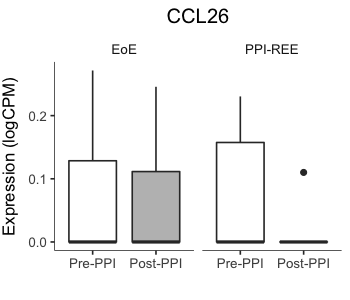

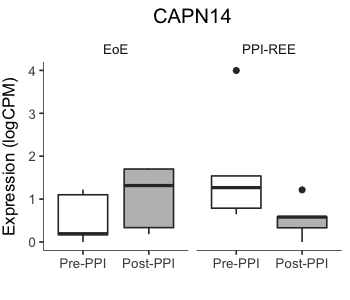

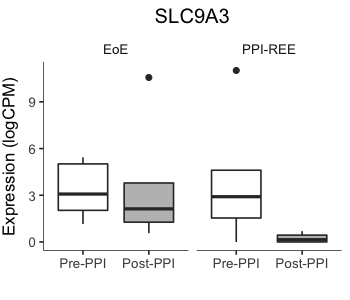

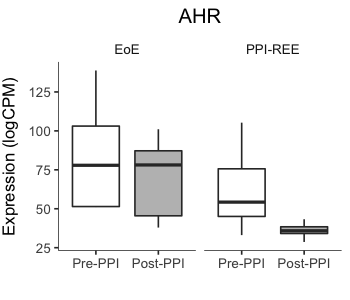

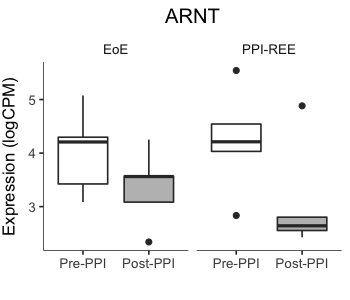

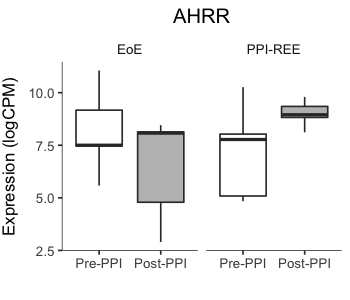

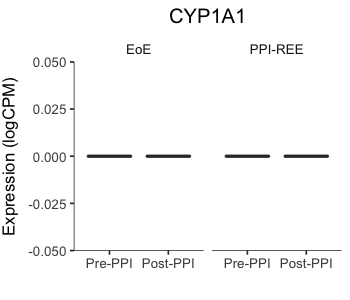

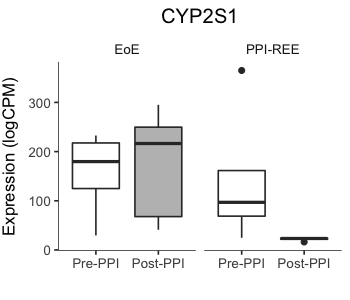

In [12]:
# Define function
def gene_boxplot(gene_symbol):
    plot_dataframe = logcpm_dataframe.loc[gene_symbol].rename_axis('sample').reset_index().merge(metadata_dataframe, on='sample').rename(columns={gene_symbol: 'expression'})
    %R -h 300 -w 350 -r 110 -i plot_dataframe,gene_symbol gene_boxplot(plot_dataframe,gene_symbol)

# Plot
for gene in genes:
    gene_boxplot(gene)

## 2. Scatter Plot

In [128]:
%%R
max(plot_dataframe[,c('Post_PPI', 'Pre_PPI')])

[1] 91.0016


In [173]:
plot_dataframe.head()

treatment patient_nr group   Post_PPI    Pre_PPI sample_names
0                p01   EoE  52.449522  91.001603      BEL>BGX
1                p02   EoE  73.128816  61.077298      BJW>BNW
2                p03   EoE  34.109395  42.470648      BBZ>BEQ
3                p04   EoE  57.840065  73.275754      BFH>BMS
4                p05   EoE  70.093506  71.288466      BKK>BPY

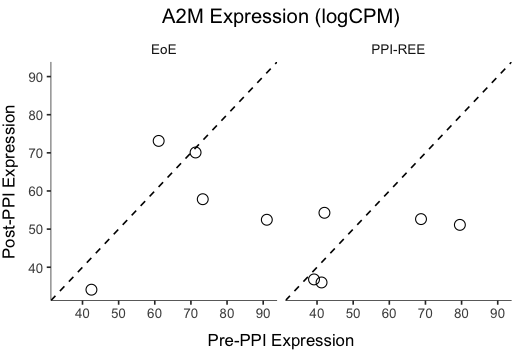

In [187]:
%%R -i plot_dataframe,gene_symbol -h 350 -w 520 -r 110
gene_scatter <- function(plot_dataframe, gene_symbol) {
    vals <- plot_dataframe[,c('Post_PPI', 'Pre_PPI')]
    lim <- c(min(vals), max(vals))
#    plot_dataframe$treatment <- factor(plot_dataframe$treatment, levels = c('Pre-PPI','Post-PPI'), ordered = TRUE)
    ggplot(plot_dataframe, aes(x=Pre_PPI, y=Post_PPI)) +
        geom_point(shape=1, size=3) +
#         geom_text(aes(label=sample_names), check_overlap=TRUE, size=3, hjust=-0.15) +
#         geom_density2d() + 
        facet_wrap(~group) +
        geom_abline(intercept=0, slope=1, linetype=2) +
        scale_x_continuous(lim=lim) + 
        scale_y_continuous(lim=lim) + 
        labs(title = paste(gene_symbol, 'Expression (logCPM)'), x = 'Pre-PPI Expression', y = 'Post-PPI Expression', color = '', fill='') +
#         guides(fill=FALSE) +
        theme_classic() +
        theme(axis.title.x = element_text(vjust=-1), axis.title.y = element_text(vjust=2.5), axis.line = element_line(colour = 'black', size=0.2), strip.background = element_rect(color='black', fill='white', size=0), plot.title = element_text(hjust = 0.5)) 
}
gene_scatter(plot_dataframe, gene_symbol)

In [208]:
    plot_dataframe = logcpm_dataframe.loc[gene_symbol].rename_axis('sample').reset_index().merge(metadata_dataframe, on='sample').rename(columns={gene_symbol: 'expression'}).pivot_table(index=['patient_nr', 'group'], columns='treatment', values='expression').reset_index().rename(columns={'Pre-PPI': 'Pre_PPI', 'Post-PPI': 'Post_PPI'})
    matched_dict = metadata_dataframe.pivot(index='patient_nr', columns='treatment', values='sample').to_dict(orient='index')
    plot_dataframe['sample_names'] = ['{Pre-PPI}>{Post-PPI}'.format(**matched_dict[x]) for x in plot_dataframe['patient_nr']]
    for group in ['Pre-PPI', 'Post-PPI']:
        plot_dataframe[group] = [matched_dict[x][group] for x in plot_dataframe['patient_nr']]
    plot_dataframe['diff'] = [rowData['Post_PPI'] - rowData['Pre_PPI'] for index, rowData in plot_dataframe.iterrows()]
    

In [214]:
plot_dataframe.head()

treatment patient_nr group   Post_PPI    Pre_PPI sample_names Pre-PPI  \
0                p01   EoE  52.449522  91.001603      BEL>BGX     BEL   
1                p02   EoE  73.128816  61.077298      BJW>BNW     BJW   
2                p03   EoE  34.109395  42.470648      BBZ>BEQ     BBZ   
3                p04   EoE  57.840065  73.275754      BFH>BMS     BFH   
4                p05   EoE  70.093506  71.288466      BKK>BPY     BKK   

treatment Post-PPI       diff  
0              BGX -38.552081  
1              BNW  12.051519  
2              BEQ  -8.361253  
3              BMS -15.435689  
4              BPY  -1.194960

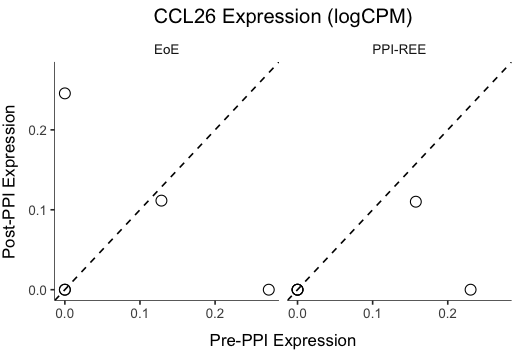

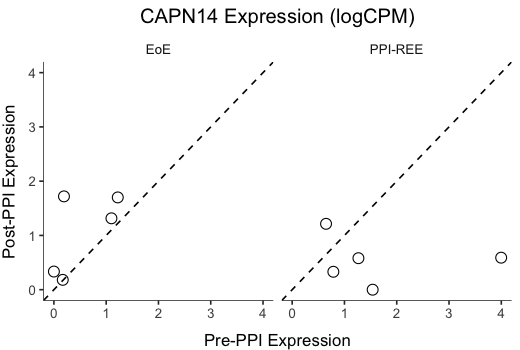

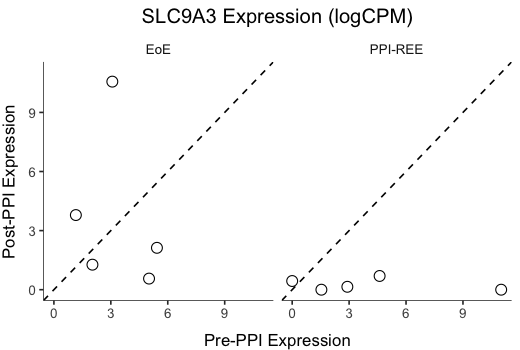

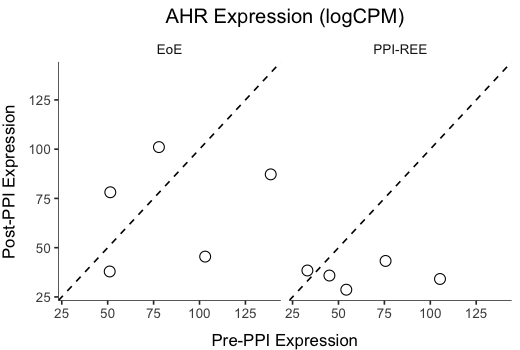

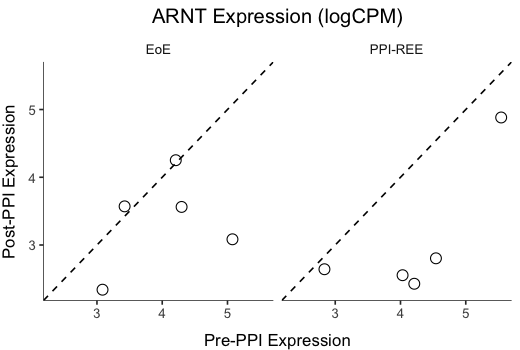

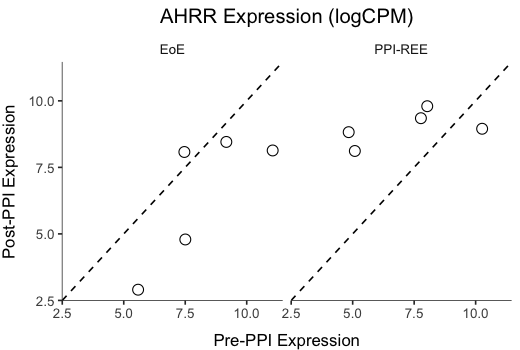

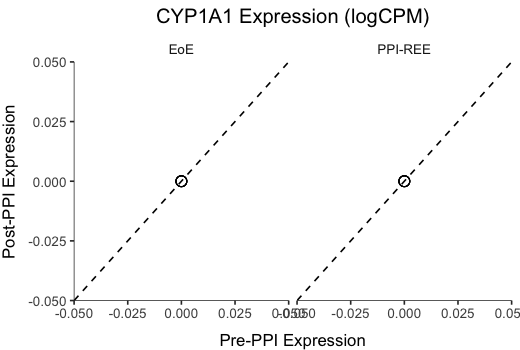

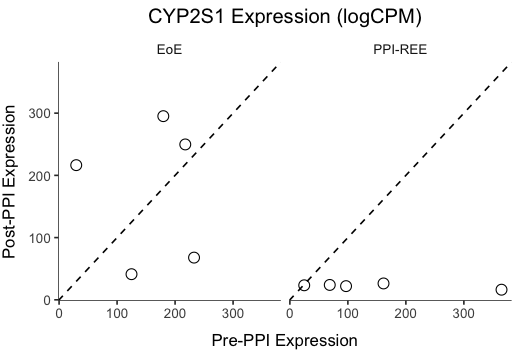

In [203]:
# Define function
def gene_scatter(gene_symbol):
    plot_dataframe = logcpm_dataframe.loc[gene_symbol].rename_axis('sample').reset_index().merge(metadata_dataframe, on='sample').rename(columns={gene_symbol: 'expression'}).pivot_table(index=['patient_nr', 'group'], columns='treatment', values='expression').reset_index().rename(columns={'Pre-PPI': 'Pre_PPI', 'Post-PPI': 'Post_PPI'})
    matched_dict = metadata_dataframe.pivot(index='patient_nr', columns='treatment', values='sample').to_dict(orient='index')
    plot_dataframe['sample_names'] = ['{Pre-PPI}>{Post-PPI}'.format(**matched_dict[x]) for x in plot_dataframe['patient_nr']]
    for group in ['Pre-PPI', 'Post-PPI']:
        plot_dataframe[group] = [matched_dict[x][group] for x in plot_dataframe['patient_nr']]
    plot_dataframe['diff'] = [rowData['Post_PPI'] - rowData['Pre_PPI'] for index, rowData in plot_dataframe.iterrows()]
    %R -i plot_dataframe,gene_symbol -h 350 -w 520 -r 110 print(gene_scatter(plot_dataframe, gene_symbol))

# Plot
for gene in genes:
    gene_scatter(gene)

## 3. Arrow Plot

In [244]:
plot_dataframe.head()

treatment patient_nr group   Post_PPI    Pre_PPI sample_names Pre-PPI  \
0                p01   EoE  52.449522  91.001603      BEL>BGX     BEL   
1                p02   EoE  73.128816  61.077298      BJW>BNW     BJW   
2                p03   EoE  34.109395  42.470648      BBZ>BEQ     BBZ   
3                p04   EoE  57.840065  73.275754      BFH>BMS     BFH   
4                p05   EoE  70.093506  71.288466      BKK>BPY     BKK   

treatment Post-PPI       diff  
0              BGX -38.552081  
1              BNW  12.051519  
2              BEQ  -8.361253  
3              BMS -15.435689  
4              BPY  -1.194960

In [257]:
%%R -i plot_dataframe,gene_symbol -h 1000 -w 1600 -r 200
arrow_plot <- function(plot_dataframe,gene_symbol) {
gp <- ggplot(plot_dataframe) +
    geom_point(aes(x=Pre_PPI, y=reorder(sample_names, -diff)), color='blue') +
    geom_point(aes(x=Post_PPI, y=reorder(sample_names, -diff)), color='red') +
    geom_segment(aes(x=Pre_PPI, xend=Post_PPI, y=sample_names, yend=sample_names, color=group), arrow = arrow(length = unit(0.03, "npc"))) +
    scale_color_manual(values=c('black', 'grey'), name='Group') +
    labs(title = paste(gene_symbol, 'Expression'), x = 'Expression (logCPM)', y = 'Patient', color = '', fill='') +
    theme_classic() +
    theme(axis.title.x = element_text(vjust=-1), axis.title.y = element_text(vjust=2.5), axis.line = element_line(colour = 'black', size=0.2), strip.background = element_rect(color='black', fill='white', size=0));
    print(gp);
    ggsave(paste0('pipeline/notebooks/plots/', gene_symbol, '-arrow.pdf'), gp)
}
# arrow_plot(plot_dataframe,gene_symbol) 

/Users/maayanlab/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:

Saving 4.73 x 3.18 in image




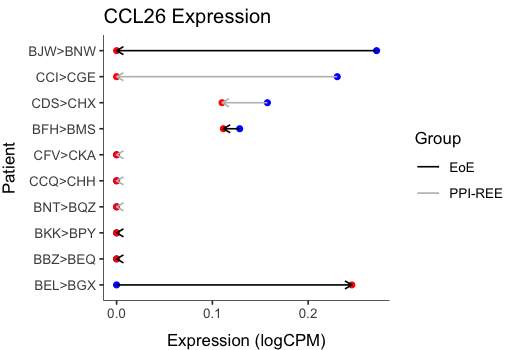

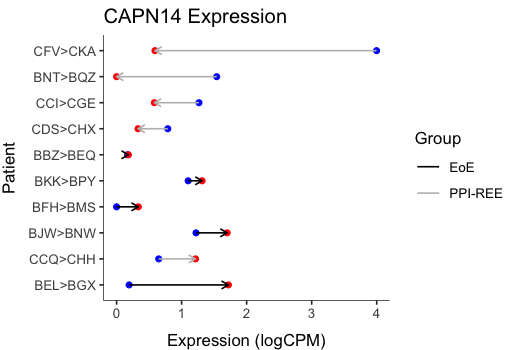

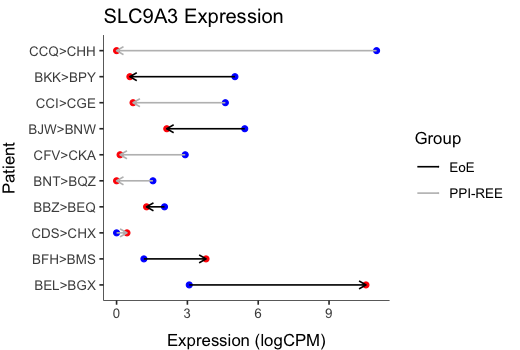

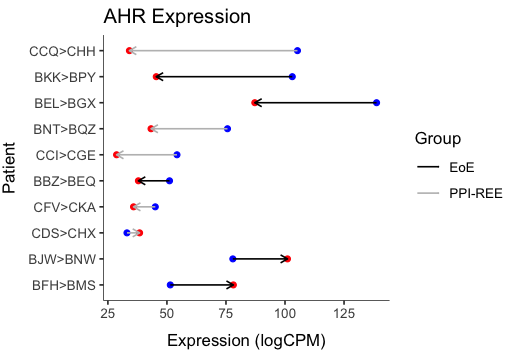

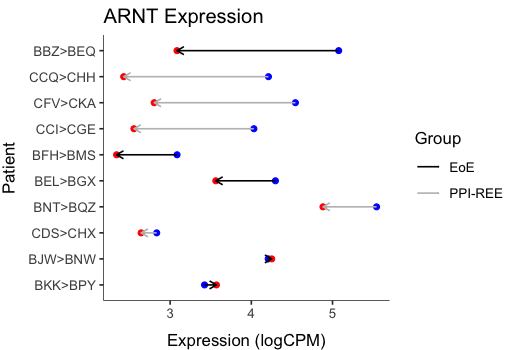

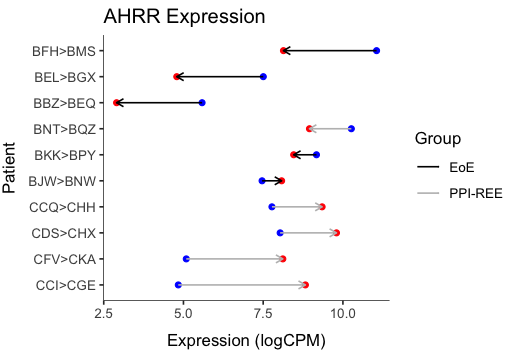

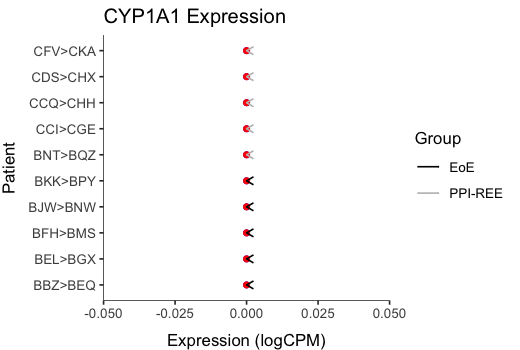

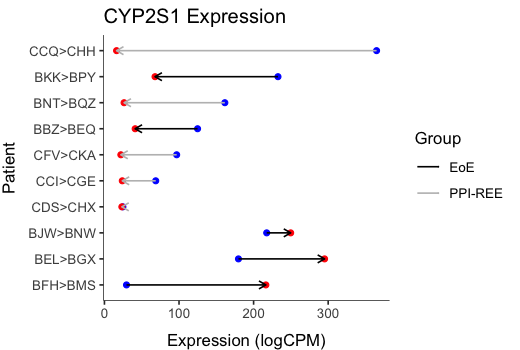

In [258]:
# Define function
def gene_arrow(gene_symbol):
    plot_dataframe = logcpm_dataframe.loc[gene_symbol].rename_axis('sample').reset_index().merge(metadata_dataframe, on='sample').rename(columns={gene_symbol: 'expression'}).pivot_table(index=['patient_nr', 'group'], columns='treatment', values='expression').reset_index().rename(columns={'Pre-PPI': 'Pre_PPI', 'Post-PPI': 'Post_PPI'})
    matched_dict = metadata_dataframe.pivot(index='patient_nr', columns='treatment', values='sample').to_dict(orient='index')
    plot_dataframe['sample_names'] = ['{Pre-PPI}>{Post-PPI}'.format(**matched_dict[x]) for x in plot_dataframe['patient_nr']]
    for group in ['Pre-PPI', 'Post-PPI']:
        plot_dataframe[group] = [matched_dict[x][group] for x in plot_dataframe['patient_nr']]
    plot_dataframe['diff'] = [rowData['Post_PPI'] - rowData['Pre_PPI'] for index, rowData in plot_dataframe.iterrows()]
    %R -i plot_dataframe,gene_symbol -h 350 -w 520 -r 110 arrow_plot(plot_dataframe, gene_symbol)

# Plot
for gene in genes:
    gene_arrow(gene)

In [26]:
gene_symbol = 'A2M'

In [68]:
plot_dataframe = logcpm_dataframe.loc[gene_symbol].rename_axis('sample').reset_index().merge(metadata_dataframe, on='sample').rename(columns={gene_symbol: 'expression'})
plot_dataframe.head()

sample  expression group treatment patient_nr
0    BBZ   42.470648   EoE   Pre-PPI        p03
1    BEL   91.001603   EoE   Pre-PPI        p01
2    BEQ   34.109395   EoE  Post-PPI        p03
3    BFH   73.275754   EoE   Pre-PPI        p04
4    BGX   52.449522   EoE  Post-PPI        p01

In [44]:
genes = ['CCL26', 'CAPN14', 'SLC9A3', 'AHR', 'ARNT', 'AHRR', 'CYP1A1', 'CYP2S1']

In [52]:
plot_dataframe = pd.melt(logcpm_dataframe.reindex(genes).reset_index(), id_vars='gene_symbol', var_name='sample', value_name='expression').merge(metadata_dataframe, on='sample')
plot_dataframe.head()

gene_symbol sample  expression group treatment patient_nr
0       CCL26    BBZ    0.000000   EoE   Pre-PPI        p03
1      CAPN14    BBZ    0.169206   EoE   Pre-PPI        p03
2      SLC9A3    BBZ    2.030469   EoE   Pre-PPI        p03
3         AHR    BBZ   51.100142   EoE   Pre-PPI        p03
4        ARNT    BBZ    5.076173   EoE   Pre-PPI        p03

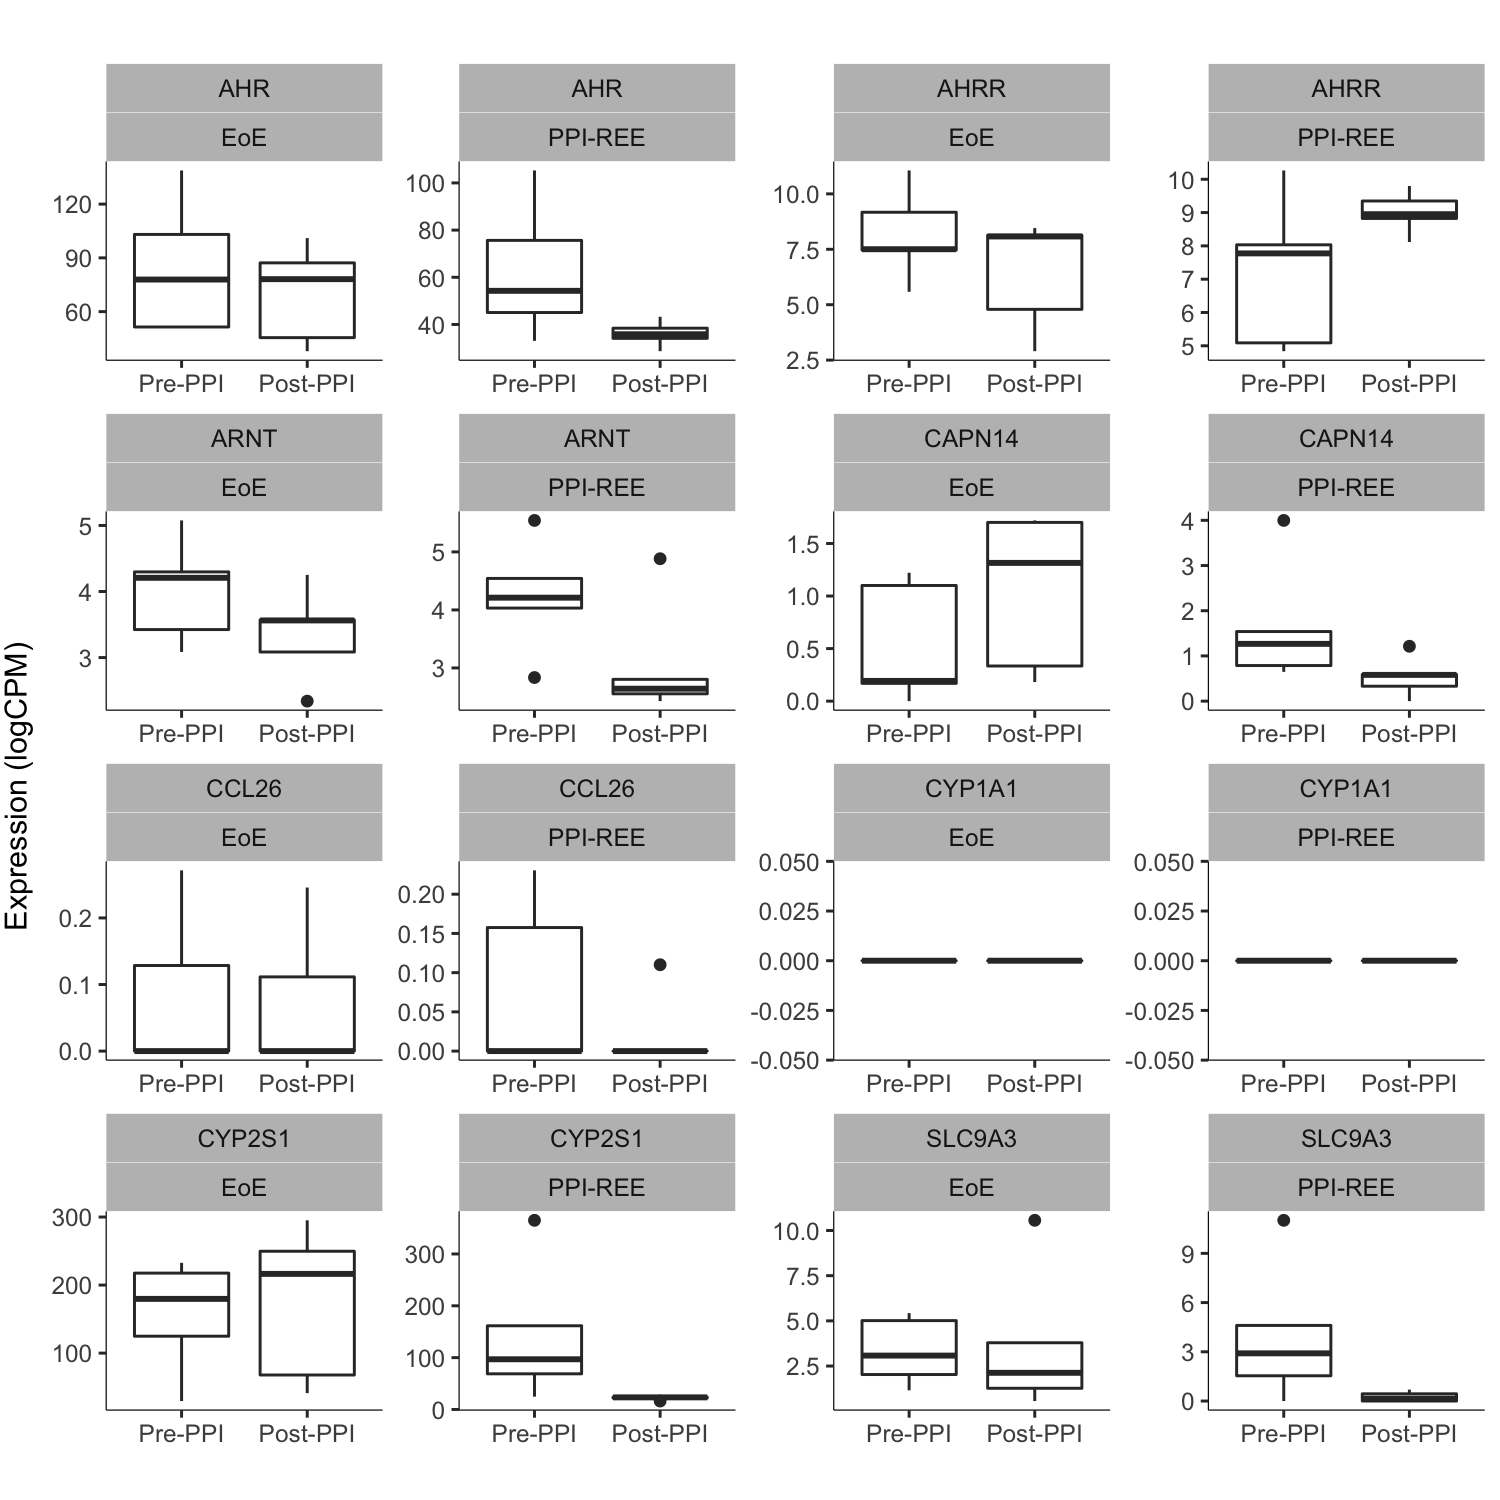

In [62]:
%%R -i plot_dataframe -h 1500 -w 1500 -r 200
#ticks <- seq()
plot_dataframe$treatment <- factor(plot_dataframe$treatment, levels = c('Pre-PPI','Post-PPI'), ordered = TRUE)
ggplot(plot_dataframe, aes(x=treatment, y=expression)) +
    geom_boxplot() +
    facet_wrap(gene_symbol~group, scales='free') +
    #coord_flip() +
    #scale_fill_manual(values=c('', '')) +
    #scale_fill_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
    #scale_color_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
    #scale_x_log10() +
    #scale_y_log10() +
    #scale_x_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks, trans='log10') +
    #scale_y_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks, trans='log10') +
    #ggtitle('') +
    #geom_abline(intercept=0, slope=1) +
    #xlab('') +
    #ylab('') +
    labs(title = '', x = '', y = 'Expression (logCPM)', color = '', fill='') +
    #guides(fill=FALSE) +
    theme_classic() +
    theme(axis.title.x = element_text(vjust=-1), axis.title.y = element_text(vjust=2.5), axis.line = element_line(colour = 'black', size=0.2), strip.background = element_rect(color='black', fill='grey', size=0))